In [1]:
from huggingface_hub import snapshot_download
snapshot_download(repo_id="pchlenski/gpt2-transcoders", allow_patterns=["*.pt"],
    local_dir="/workspace/transcoder_circuits/gpt-2-small-transcoders", local_dir_use_symlinks=False
)

/workspace/transcoder_circuits/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]/workspace/transcoder_circuits/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1194: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 26 files: 100%|██████████| 26/26 [00:00<00:00, 784.37it/s]


'/workspace/transcoder_circuits/gpt-2-small-transcoders'

In [2]:
import transformer_lens as tl
model = tl.HookedTransformer.from_pretrained("gpt2")
model.set_use_hook_mlp_in(True)

/workspace/transcoder_circuits/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [3]:
# flake8: noqa
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *
from sae_training.sparse_autoencoder import SparseAutoencoder

transcoder_template = "/workspace/transcoder_circuits/gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoders = []
for i in range(model.cfg.n_layers):
    transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())

In [4]:
hook_point: tl.hook_points.HookPoint
for hook_point in model.hook_points():
    print(hook_point.name)

hook_embed
hook_pos_embed
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_mid
blocks.0.hook_resid_post
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.attn.hook_v
blocks.1.attn.hook_z
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_pattern
blocks.1.attn.hook_result
blocks.1.mlp.hook_pre
blocks.1.mlp.hook_post
blocks.1.hook_attn_in
blocks.1.hook_q_input
blocks.1.hook_k_input
blocks.1.hook_v_input
blocks.1.hook_mlp_in


In [5]:
# 
text = "When John and Mary went to the shops, John gave the bag to Mary"

def metric(model, text): 
    loss, _ = model.run_with_cache(text, return_type="loss", loss_per_token=True)
    return loss[0,-1]

In [54]:
import collections

tensors = collections.defaultdict(dict)

def get_layer(name):
    return int(name.split(".")[1])

def cache_mlp_in_hook(acts, hook):
    assert "ln2.hook_normalized" in hook.name, hook.name
    tensors[hook.name]["activations"] = acts

def patch_mlp_out_hook(acts, hook, add_err):
    assert "hook_mlp_out" in hook.name, hook.name
    global tensors
    input_hook_name = hook.name.replace("hook_mlp_out", "ln2.hook_normalized")
    inputs = tensors[input_hook_name]["activations"]
    transcoder = transcoders[get_layer(hook.name)]
    
    transcoder_out, transcoder_hidden = transcoder(inputs)[:2]
    transcoder_err = (acts - transcoder_out.detach())
    transcoder_hidden.retain_grad()
    transcoder_err.retain_grad()
    tensors[input_hook_name]["transcoder_hidden"] = transcoder_hidden 
    tensors[input_hook_name]["transcoder_err"] = transcoder_err
    acts_patch = transcoder_out
    if add_err: acts_patch += transcoder_err
    return acts_patch

def compute_grad_hook(acts: Float[Tensor, "batch seq d_model"], hook):
    """
    Input: grad w.r.t mlp out
    """
    # NOTE: this will be called from MLP out
    pass

def cache_grad_hook(acts, hook):
    global tensors
    print("Calling hook from point: ", hook.name)
    transcoder_hidden = tensors[hook.name]["transcoder_hidden"]
    transcoder_err = tensors[hook.name]["transcoder_err"]
    assert transcoder_hidden.grad is not None 
    assert transcoder_err.grad is not None
    tensors[hook.name]["grad_transcoder_hidden"] = transcoder_hidden.grad
    tensors[hook.name]["grad_transcoder_err"] = transcoder_err.grad 

def passthrough_hook(acts, hook):
    return (acts,)
    

In [68]:
ADD_ERR: bool = False
from functools import partial

tensors = collections.defaultdict(dict)
model.reset_hooks()
losses_with_patching = []
for layer in [0]: # range(model.cfg.n_layers):
    model.add_hook(f"blocks.{layer}.ln2.hook_normalized", cache_mlp_in_hook, "fwd")
    model.add_hook(f"blocks.{layer}.hook_mlp_out", partial(patch_mlp_out_hook, add_err = ADD_ERR), "fwd")

    m = metric(model, text)
    model.reset_hooks()
    model.add_hook(f"blocks.{layer}.ln2.hook_normalized", cache_grad_hook, "bwd")
    model.add_hook(f"blocks.{layer}.hook_mlp_out", passthrough_hook, "bwd")
    m.backward()
    losses_with_patching.append(m.item())

print(tensors['blocks.0.ln2.hook_normalized'].keys())

dict_keys(['activations', 'transcoder_hidden', 'transcoder_err'])


In [79]:
ADD_ERR: bool = False
from functools import partial

model.reset_hooks()

losses_with_patching = []
for layer in [0]: # range(model.cfg.n_layers):
    with model.hooks(
        fwd_hooks = [
            (f"blocks.{layer}.ln2.hook_normalized", cache_mlp_in_hook),
            (f"blocks.{layer}.hook_mlp_out", partial(patch_mlp_out_hook, add_err = ADD_ERR))
        ],
        bwd_hooks = [
            (f"blocks.{layer}.ln2.hook_normalized", cache_grad_hook),
            (f"blocks.{layer}.ln2.hook_normalized", passthrough_hook),
            (f"blocks.{layer}.hook_mlp_out", passthrough_hook)
        ]
    ):
        m = metric(model, text)
        print(tensors['blocks.0.ln2.hook_normalized'])
        m.backward(retain_graph = True)
        losses_with_patching.append(m.item())

    # model.add_hook(f"blocks.{layer}.ln2.hook_normalized", cache_mlp_in_hook, "fwd")
    # model.add_hook(f"blocks.{layer}.hook_mlp_out", partial(patch_mlp_out_hook, add_err = ADD_ERR), "fwd")

{'activations': tensor([[[ 0.7464, -0.1910,  0.0773,  ..., -0.0055,  0.1420,  0.3190],
         [ 0.3449, -0.0457, -0.2843,  ...,  0.1978, -0.0891,  0.0697],
         [ 0.1015,  0.7107, -0.0086,  ...,  0.0620,  0.0125, -0.0666],
         ...,
         [ 1.8188,  0.4497, -0.3051,  ...,  0.0239, -0.0084,  0.2511],
         [ 1.3533,  0.0332,  0.4540,  ..., -0.0703,  0.0275,  0.0136],
         [-0.4471,  1.0301,  0.2498,  ..., -0.0841, -0.1352, -0.0315]]],
       device='cuda:0', grad_fn=<BackwardHookFunctionBackward>), 'transcoder_hidden': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<ReluBackward0>), 'transcoder_err': tensor([[[-0.0170,  0.0082,  0.0140,  ...,  0.0476,  0.0472, -0.0017],
         [-0.2847, -0.0702, -0.0311,  ...,  0.0482, -0.

In [80]:
print(tensors['blocks.0.ln2.hook_normalized'].keys())

dict_keys(['activations', 'transcoder_hidden', 'transcoder_err'])


In [81]:
print(t)

NameError: name 't' is not defined

In [ ]:
print(tensors.keys())
for mo

<Axes: >

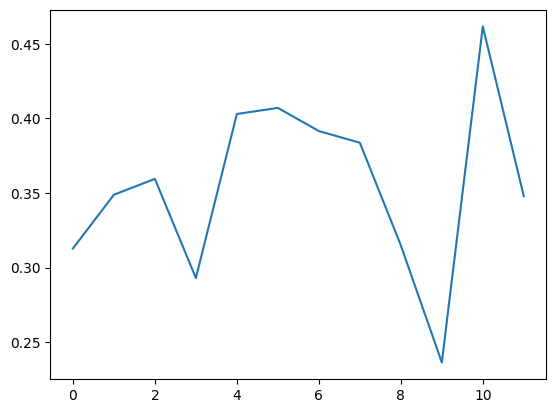

In [ ]:
import seaborn as sns
sns.lineplot(x = range(len(losses_with_patching)), y = losses_with_patching)

Remarks:
- Loss increase w/ patching is really bad
- TODO: check implementation details, such as whether we normalise, subtract decoder bias, ... 
- Prolly ask the authors. 

In [ ]:
def patch_sae_hook(acts, hook, sae):
    assert "ln2.hook_normalized" in hook.name, hook.name
    tensors[hook.name]["activations"] = acts

def patch_mlp_out_hook(acts, hook, add_err):
    assert "hook_mlp_out" in hook.name, hook.name
    global activations
    inputs = activations[hook.name.replace("hook_mlp_out", "ln2.hook_normalized")]["activations"]
    transcoder = transcoders[get_layer(hook.name)]
    
    transcoder_out = transcoder(inputs)[0]
    transcoder_err = (acts - transcoder_out.detach())
    acts_patch = transcoder_out
    if add_err: acts_patch += transcoder_err
    return acts_patch